# The QNLP Pipeline for Twitter Sentiment Analysis
## 1. Load the preprocessed data

In [1]:
import collections
import pickle
import warnings
warnings.filterwarnings("ignore")
import os
from random import shuffle
import random
from discopy.tensor import Tensor
from discopy import Word
from discopy.rigid import Functor
from discopy import grammar
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from jax import numpy as np
import numpy
from lambeq import AtomicType, IQPAnsatz, remove_cups, NumpyModel, spiders_reader
from lambeq import BobcatParser, TreeReader, cups_reader, DepCCGParser
from lambeq import Dataset
from lambeq import QuantumTrainer, SPSAOptimizer
from lambeq import TketModel
from lambeq import Rewriter
from pytket.extensions.qiskit import AerBackend
import seaborn as sns
import matplotlib.pyplot as plt
from pytket.circuit.display import render_circuit_jupyter

pd.set_option('display.width', 1000)
pd.options.display.max_colwidth=80
print(os.getcwd())
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false"
BATCH_SIZE = 20
EPOCHS = 100
SEED = 0

TRAIN_INDEX_RATIO = 0.8
VAL_INDEX_RATIO = TRAIN_INDEX_RATIO + 0.1
TEST_INDEX_RATIO = VAL_INDEX_RATIO + 0.1

assert TEST_INDEX_RATIO <= 1

def load_pickled_dict_to_df(filename):
    saved_dict = pickle.load(open(filename, 'rb'))
    df =  pd.DataFrame.from_dict(saved_dict)
    df =  df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    sentiment = []
    for i in df['target']:
        if i == "Positive":
            sentiment.append(1)
        else:
            sentiment.append(0)
    df["Sentiment"] = sentiment
    return df

cleaned_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data.pkl')
cleaned_lemmatized_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data_lematize.pkl')
cleaned_lemmatized_stemmed_qnlp_filename = os.path.join(os.getcwd(), 'cleaned_qnlp_data_stem_lematize.pkl')

#cleaned_qnlp = load_pickled_dict_to_df(cleaned_qnlp_filename)

#cleaned_lemmatized_qnlp = load_pickled_dict_to_df(cleaned_lemmatized_qnlp_filename)

cleaned__lemmatized_stemmed_qnlp = load_pickled_dict_to_df(cleaned_lemmatized_stemmed_qnlp_filename)

/home/peiyongw/Desktop/Hackathon-QNLP


In [ ]:
cleaned_qnlp.head(10)

In [ ]:
cleaned_qnlp.info()

In [ ]:
sns.countplot(x = "target", data = cleaned_qnlp)

In [ ]:
cleaned_lemmatized_qnlp.head(10)

In [ ]:
cleaned_lemmatized_qnlp.info()

In [ ]:
sns.countplot(x='target', data = cleaned_lemmatized_qnlp)

In [2]:
cleaned__lemmatized_stemmed_qnlp.head(10)

,data,label,target,Sentiment
0,king you for your servic,"[0, 1]",Positive,1
1,epic store close hahahah gta v kill it,"[0, 1]",Positive,1
2,fuck no that s back when everybodi didn t miss lmao,"[1, 0]",Negative,0
3,fifa wa so pain,"[1, 0]",Negative,0
4,call of duti alway got across a fuckin updat,"[1, 0]",Negative,0
5,remot work and an increas in cloud base data is spur cyber attack today see ...,"[0, 1]",Positive,1
6,i start be realli into play battlefield hardlin it s differ than most other ...,"[0, 1]",Positive,1
7,fuck sleep got ta watch the reveal trailer for cod black op cold war later a...,"[0, 1]",Positive,1
8,kill yourself and your playoverwatch s fault fuck you,"[1, 0]",Negative,0
9,nice player model rhandlerr fix it pic twitter com,"[1, 0]",Negative,0


In [3]:
cleaned__lemmatized_stemmed_qnlp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2578 entries, 0 to 2577
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   data       2578 non-null   object
 1   label      2578 non-null   object
 2   target     2578 non-null   object
 3   Sentiment  2578 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 80.7+ KB


<AxesSubplot:xlabel='target', ylabel='count'>

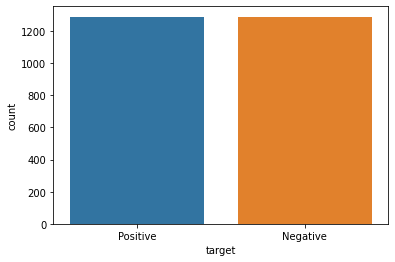

In [4]:
sns.countplot(x='target', data = cleaned__lemmatized_stemmed_qnlp)

## 2. Train QNLP Models for Different-Preprocessed Data
Since the limited parsing and training speed using on the CPU, we'll only use a fraction of our data.

In [5]:
# parser = BobcatParser(verbose='text')
# parser = DepCCGParser(root_cats=['S[dcl]'])
parser = spiders_reader
NUM_DATA = 2578

loss = lambda y_hat, y: -np.sum(y * np.log(y_hat)) / len(y)  # binary cross-entropy loss
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting
rewriter = Rewriter(['prepositional_phrase', 'determiner', 'auxiliary', 'connector', 
                         'coordination', 'object_rel_pronoun', 'subject_rel_pronoun',
                        'postadverb', 'preadverb'])
def rewrite(diagram):
    # diagram = rewriter(diagram)
    return remove_cups(diagram)

def create_diagrams_and_labels(total_df, NUM_DATA = 2578):
    total_text = total_df['data'].tolist()
    total_labels = total_df["Sentiment"].tolist()
    total_labels = [[t, 1-t] for t in total_labels] # [1, 0] for positive, [0, 1] for negative
    train_diagrams = parser.sentences2diagrams(total_text[:round(NUM_DATA*TRAIN_INDEX_RATIO)])
    train_labels = total_labels[:round(NUM_DATA*TRAIN_INDEX_RATIO)]
    dev_diagrams = parser.sentences2diagrams(total_text[round(NUM_DATA*TRAIN_INDEX_RATIO):round(NUM_DATA*VAL_INDEX_RATIO)])
    dev_labels = total_labels[round(NUM_DATA*TRAIN_INDEX_RATIO):round(NUM_DATA*VAL_INDEX_RATIO)]
    test_diagrams = parser.sentences2diagrams(total_text[round(NUM_DATA*VAL_INDEX_RATIO):round(NUM_DATA*TEST_INDEX_RATIO)])
    test_labels = total_labels[round(NUM_DATA*VAL_INDEX_RATIO):round(NUM_DATA*TEST_INDEX_RATIO)]
    
    return train_diagrams, train_labels, dev_diagrams, dev_labels, test_diagrams, test_labels

### 2.1 Data with both Lemmatization and Stemming
#### 2.1.1 Create diagrams

In [6]:
raw_train_diagrams_1, train_labels_1, raw_dev_diagrams_1, dev_labels_1, raw_test_diagrams_1, test_labels_1 = create_diagrams_and_labels(cleaned__lemmatized_stemmed_qnlp)
print(len(raw_train_diagrams_1))

2062


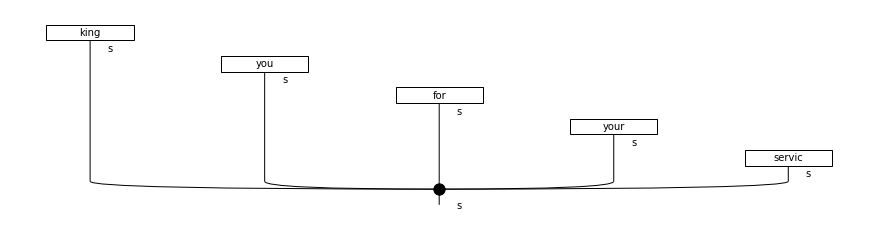

In [7]:
raw_train_diagrams_1[0].draw(figsize=(12,3))

#### 2.1.2 Simplify the diagrams

In [8]:
train_diagrams_1 = [rewrite(diagram) for diagram in raw_train_diagrams_1]
dev_diagrams_1 = [rewrite(diagram) for diagram in raw_dev_diagrams_1]
test_diagrams_1 = [rewrite(diagram) for diagram in raw_test_diagrams_1]

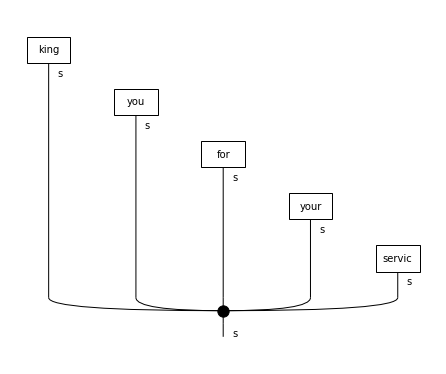

In [9]:
train_diagrams_1[0].draw(figsize=(6,5))

#### 2.1.3 Create circuits

In [11]:
ansatz_1 = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1, AtomicType.PREPOSITIONAL_PHRASE: 1, AtomicType.NOUN_PHRASE:1, AtomicType.CONJUNCTION:1}, n_layers=1, n_single_qubit_params=3)
train_circuits_1 = [ansatz_1(diagram) for diagram in train_diagrams_1]
dev_circuits_1 =  [ansatz_1(diagram) for diagram in dev_diagrams_1]
test_circuits_1 = [ansatz_1(diagram) for diagram in test_diagrams_1]

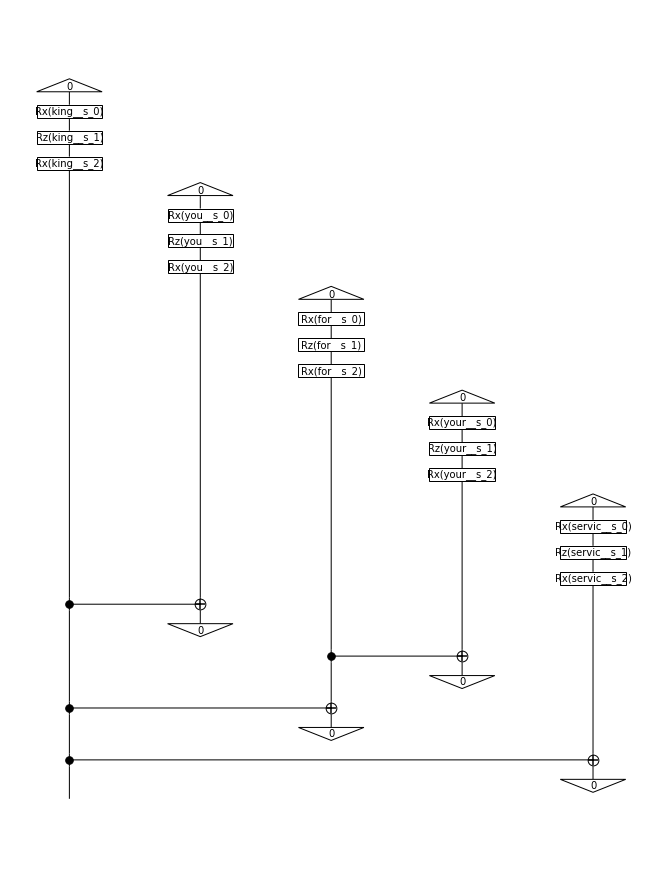

In [12]:
train_circuits_1[0].draw(figsize=(9, 12))

In [13]:
# train_circuits_1[0].draw(figsize=(9, 12))
render_circuit_jupyter(train_circuits_1[0].to_tk())

In [14]:
[(s, s.size) for s in train_circuits_1[0].free_symbols]

[(servic__s_1, 1),
 (servic__s_0, 1),
 (for__s_1, 1),
 (for__s_2, 1),
 (king__s_1, 1),
 (king__s_0, 1),
 (you__s_1, 1),
 (servic__s_2, 1),
 (your__s_1, 1),
 (you__s_0, 1),
 (your__s_0, 1),
 (your__s_2, 1),
 (for__s_0, 1),
 (king__s_2, 1),
 (you__s_2, 1)]

#### 2.1.4 Parameterise

In [15]:
all_circuits_1 = train_circuits_1 + dev_circuits_1 + test_circuits_1
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 2048
}
model_1 = NumpyModel.from_diagrams(all_circuits_1, use_jit=True)
# model_1 = TketModel.from_diagrams(all_circuits_1, backend_config=backend_config)

#### 2.1.5 Initialize trainer

In [16]:
trainer_1 = QuantumTrainer(
    model_1,
    loss_function=loss,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.2, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0
)
train_dataset_1 = Dataset(
            train_circuits_1,
            train_labels_1,
            batch_size=BATCH_SIZE)

val_dataset_1 = Dataset(dev_circuits_1, dev_labels_1, shuffle=False)

#### 2.1.6 Train

In [ ]:
trainer_1.fit(train_dataset_1, val_dataset_1, logging_step=1)

#### 2.1.7 Show Results

In [ ]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(12, 8))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(trainer_1.train_epoch_costs, color=next(colours))
ax_bl.plot(trainer_1.train_results['acc'], color=next(colours))
ax_tr.plot(trainer_1.val_costs, color=next(colours))
ax_br.plot(trainer_1.val_results['acc'], color=next(colours))

test_acc_1 = acc(model_1(test_circuits_1), test_labels_1)
print('Test accuracy:', test_acc_1)